# Analyser notebook

This notebook is supposed to show how my implementation of the analysation of the sensor data works. My analysis relies on a Kalman-Filter applied to the position measurements which is convenient because it is able to smooth the data in real time. My implementation is a two-dimensional generalisation of the one-dimensional Wikipedia example at:
https://en.wikipedia.org/wiki/Kalman_filter#Example_application.2C_technical.

My Analyser class again derives from threading.Thread. It takes a queue as input and stores the result in a dictionary (sensors) which contains a list of results for each sensor ID that submits to the queue. It also takes a number of Kalman-Filter parameters, most notably:
* the initial position (pos0) and velocity (vel0) used in the filter,
* and the error on the position measurement (noise).

I assumed that we know the initial position and velocity as well as the error on the position measurement, but the assumption could be relaxed by adapting the Kalman-Filter parameters.

Even after the data is Kalman-filtered, the estimator for the total distance covered is biased when we simply add up the distances between two consecutive points. This is because the distance between two noisy measurements has a complicated distribution (non-central chi-distribution) which is not centered around the true distance. The bias is worst when the athlete is not moving at all. To suppress this effect, I hence check at each point in time if the athlete is stationary, using an hypothesis test for the consistency of the estimated velocity with zero. Only if the athlete is not stationary, I add the distance to its previous position to the total distance covered.


In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns

In [4]:
sns.set_context('poster')

In [5]:
import numpy as np

In [6]:
from time import sleep

In [7]:
from Queue import Queue

In [8]:
from streamanalysis import Athlete, Sensor, Analyser

In [9]:
athlete = Athlete(keepData=True, seed = 1)
ID = '0'
q = Queue()

In [26]:
athlete.reset()
sensor = Sensor(athlete, q, ID, verbose = True)
analyser = Analyser(q)
sensor.start()
analyser.start()
runtime = 60 * 5
sleep(runtime)
sensor.stop()

Sensor 0 started
Sensor 0 stopped


In [27]:
# Get results for chosen ID from dictionary at sensors
results = analyser.sensors[ID]

In [28]:
# Compare number of filtered measurements to ellapsed time 
nres = len(results)
print nres, runtime * 20

6000 6000


In [29]:
# Get time information from filtered measurements
delta_time = []
for i in range(nres-1):
    dt = results[i+1].time-results[i].time
    delta_time.append(dt.total_seconds())
ellapsed = np.append(0,np.cumsum(delta_time))/60.

In [30]:
print ellapsed.shape

(6000,)


In [31]:
# Extract data from results
# Position and error estimate
pos = []
pos_err = []
# Velocity and error estimate
vel = []
vel_err = []
# Estimate for total distance covered
dist = []
for r in results:
    pos.append(r.pos)
    pos_err.append(r.pos_err)
    vel.append(r.vel)
    vel_err.append(r.vel_err)
    dist.append(r.dist)
    stat.append(r.stationary)
pos = np.asarray(pos)
pos_err = np.asarray(pos_err)
vel = np.asarray(vel)
vel_err = np.asarray(vel_err)
dist = np.asarray(dist)

In [32]:
# Get true data from athlete
data = np.asarray(athlete.data)
true_pos = data[:,0]
true_vel = data[:,1]

In [33]:
# Calculate true total distance travelled
true_dist = np.append(0,np.cumsum(np.sqrt(((true_pos[1:] - true_pos[:-1])**2).sum(axis = 1))))

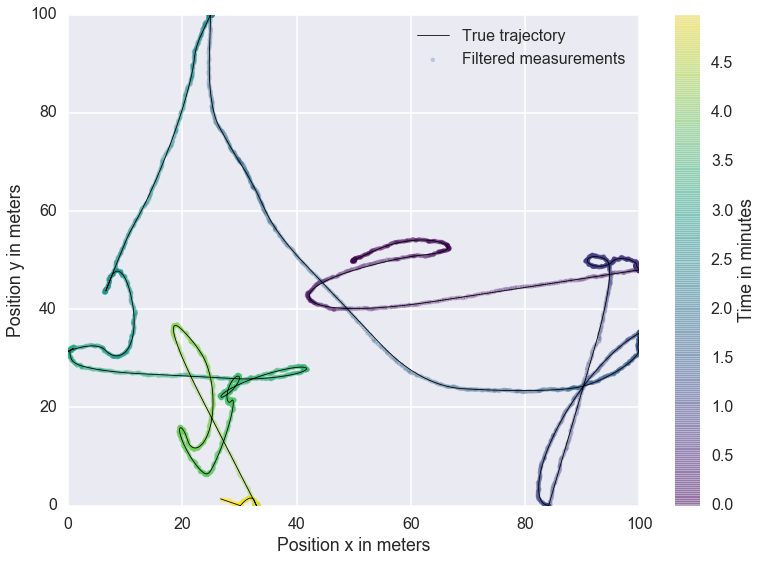

In [34]:
plt.scatter(pos[:,0], pos[:,1], c = ellapsed, alpha = .3, cmap = 'viridis',
            edgecolors='none', label = 'Filtered measurements')
plt.plot(true_pos[:,0],true_pos[:,1], color = 'k', label = 'True trajectory', lw = .8)
plt.legend(loc = 0)
plt.xlim(0,100)
plt.xlabel('Position x in meters')
plt.ylim(0,100)
plt.ylabel('Position y in meters')
_=plt.colorbar(label = 'Time in minutes')

In [35]:
# Estimate errors on position and velocity estimates by comparing them to true values
print 'Position error estimated from true data: ', (pos - true_pos).std()
print 'Position error estimated by Kalman-Filter: ', pos_err.mean()
print 'Velocity error estimated from true data: ', (vel - true_vel).std()
print 'Velocity error estimated by Kalman-Filter: ', vel_err.mean()

Position error estimated from true data:  0.14252891111
Position error estimated by Kalman-Filter:  0.142953056523
Velocity error estimated from true data:  0.50339651755
Velocity error estimated by Kalman-Filter:  0.538937387779


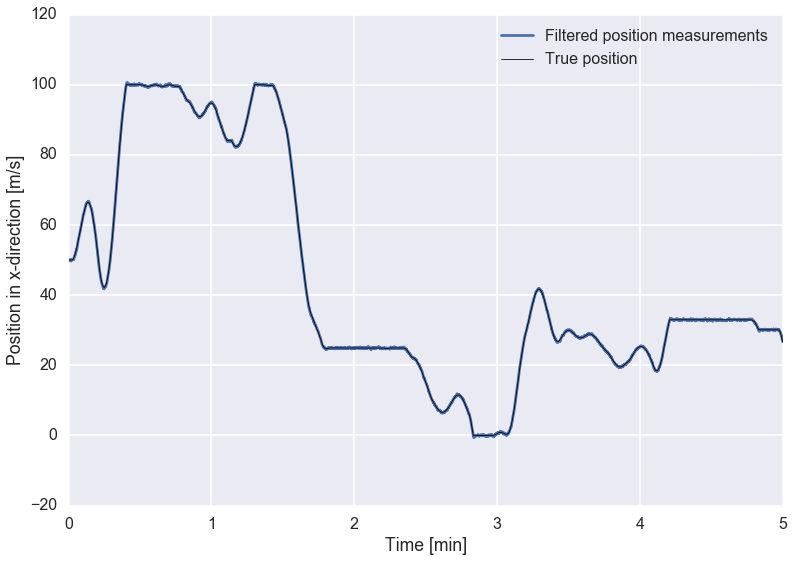

In [36]:
plt.plot(ellapsed, pos[:,0], label = 'Filtered position measurements')
plt.plot(ellapsed, true_pos[:,0], label = 'True position', color = 'k', lw = .8)
plt.xlim(0, runtime/60)
plt.ylabel('Position in x-direction [m/s]')
plt.xlabel('Time [min]')
plt.legend()

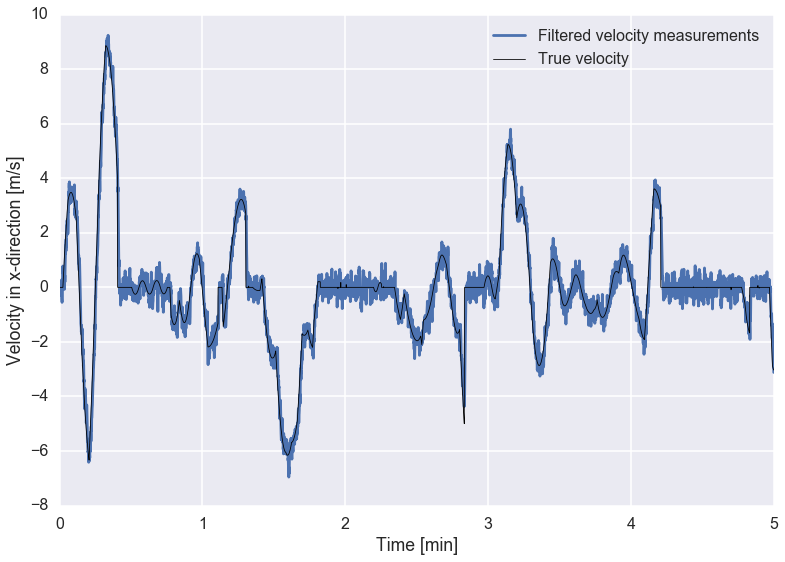

In [37]:
plt.plot(ellapsed, vel[:,0], label = 'Filtered velocity measurements')
plt.plot(ellapsed, true_vel[:,0], label = 'True velocity', color = 'k', lw = .8)
plt.xlim(0, runtime/60)
plt.ylabel('Velocity in x-direction [m/s]')
plt.xlabel('Time [min]')
plt.legend()

In [41]:
# Calculate naive estimator for the total distance:
naive_dist = np.append(0,np.cumsum(np.sqrt(((pos[1:] - pos[:-1])**2).sum(axis = 1))))

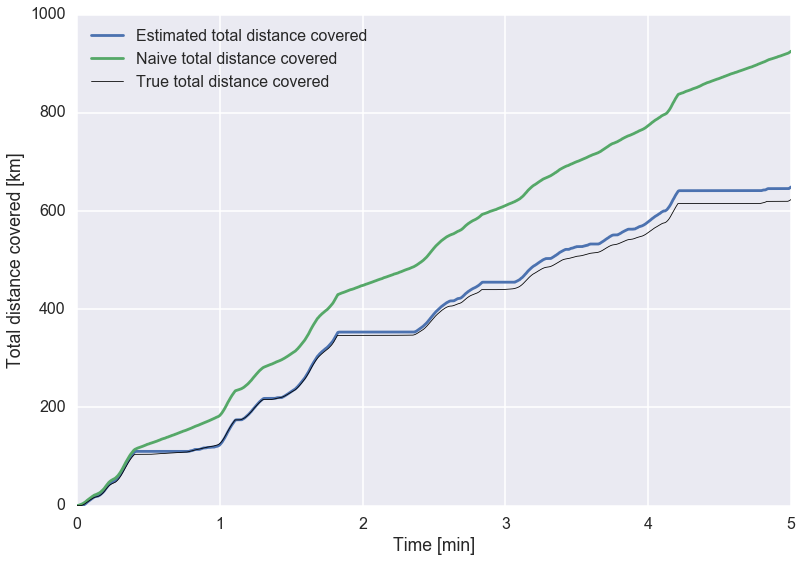

In [49]:
plt.plot(ellapsed, dist, label = 'Estimated total distance covered')
plt.plot(ellapsed, naive_dist, label = 'Naive total distance covered')
plt.plot(ellapsed, true_dist, label = 'True total distance covered', color = 'k', lw = .8)
plt.ylabel('Total distance covered [km]')
plt.xlabel('Time [min]')
plt.legend(loc = 0)